In [1]:
### GENERIC LIBRARIES #####

import matplotlib.pyplot as plt
import numpy as np
import emcee

#### DATA TREATMENT ####

import pandas as pd

######## FIT LIBRARIES ####

import lmfit
from lmfit import Parameters, Parameter


###### INTERPOLATION LIBRARIES #####

from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, brentq
from scipy.interpolate import UnivariateSpline


from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.stats import chi2_contingency


import scipy.integrate as integrate
import scipy.special as special




#########CORNER ##########


import corner
import pygtc



###############################

from lmfit.model import save_modelresult
from lmfit.model import load_modelresult

#other useful features
from inspect import signature
from numpy import log10
from numpy import pi
from scipy.optimize import minimize
#from IPython.display import display, Math
plt.rcParams['text.usetex'] = True

In [2]:
#Useful constants in SI

hbar = 1.054571817e-34 #reduced Planck constant
e = 1.60217662e-19 #elementary charge
c0 = 2.99792458e8 #speed of light in vacuum
G = 6.67430e-11 #Gravitational constant
#Solar mass
sm = 1.98847e30
#Parsec
pc = 3.0856775814913673e16


#length scale of natural units

evm = hbar*c0/e
#time scale of natural units
evs = hbar/e
#mass scale of natural units
evkg = e/c0**2

#Hubble constant (km/s/Mpc)
H = 70

om = 0.284 # matter density parameter

pcrit = 3*(H*1000/(1e6*pc))**2/(8*np.pi*G) #cosmological matter density

pom = om*pcrit #cosmological matter density

#Relevant quantities in natural units (hbar = 1, c0 = 1)

#typical axion mass (eV)
ma=1e-22

#gravitational constant
evG = G*e**2/(c0**5*hbar)
#Planck mass
evMpl = 1/np.sqrt(evG)
#Hubble constant
evH = H*1000/(pc*1e6)*hbar/e
#Cosmological critical density
rc = 3*evH**2/(8*np.pi*evG)
#NFW characteristic radius
#evrs = rs/evm
#Solar mass
evsm = sm/evkg
#Parsec
evpc=pc/evm

evpom = pom*(evm**3)/evkg #cosmological matter density

#Some general formatting settings for plotting
plt.style.use('default')
#[Note: if you encounter an error, ensure the Latex package is installed in your computer
#(or erase the line below)]
#pl.rc('text', usetex=True)
plt.rc('font', family='serif')
size=17
width=1
dash=(10,2)
i10=-1

#Radius [kpc], density [kg/m^3] and rotation curve [km/s] solution of SP equation for lambda = ma = 1
# xvals = np.loadtxt('SP_SOL/xvalues_kpc.txt')
# pvals = np.loadtxt('SP_SOL/pvalues_kgm3.txt')
# vvals = np.loadtxt('SP_SOL/vvalues_kms.txt')


from scipy.interpolate import interp1d

#Interpolated densities and velocities for the above solutions

# intvels = interp1d(xvals, vvals, kind='linear')

# intps = interp1d(xvals, pvals, kind='linear')

In [3]:
#functions required for building the prior and model

h = 0.678

fac = 102 #critical density factor
def d(c):
    return (fac/3)*c**3/(np.log(1+c)-c/(1+c))

#NFW-only DM rotation curve
def vNFW(x, c, vir):
    
    #Virial speed (m/s)
    vir = 1000*vir
    
    #Virial mass (kg)
    MV = np.sqrt(vir**6 / ((4/3)*pi*fac*pcrit*G**3))
    
    #NFW radius
    rs = (MV/(fac*pcrit*(4*np.pi/3)*c**3))**(1/3)/(1000*pc)
    
    #NFW density scale
    p0 = pcrit*d(c)
    
    #NFW rotation curve 
    def vnfw0(r):
       
        return np.sqrt(G*4*np.pi*p0*(rs*1000*pc)**3*(np.log((rs + r)/(rs)) + rs/(rs + r)\
                                                           - 1)/(1000*pc*r))/1000
    
    return vnfw0(x)

#Full rotation curve predicted
def vmodel(c, vir, lmd, lmb, R, Vgas, Vdisk, Vbul):
    
    return np.sqrt(vNFW(R, c, vir)**2 + abs(Vgas)*Vgas + lmd*abs(Vdisk)*Vdisk + lmb*abs(Vbul)*Vbul)
    
#stellar mass
def mstar(lmd, lmb, ltot, lbul):
    return lmd*(ltot - lbul) + lmb*lbul

#m-log10(c) relation
def lmcrel(mv):
    return 1.025 - 0.097*log10(mv/(sm*1e12/h))


#log-prior function (NGC 4013 galaxy)


def lprior(c, vir, lmd, lmb, R, Vobs, Vgas, Vdisk, Vbul, \
           ltot = 79.094*1e9*sm, lbul = 15.3853*1e9*sm, mh1 = 2.967*1e9*sm, vf = 172.9):
            
        
            if 1e-6 <= c <= 100 and 1e-6 <= lmd <= 100 and 1e-6 <= lmb <= 100 and 1e-6 <= vir <= 500:
                    mv = np.sqrt((vir*1000)**6 / ((4/3)*pi*fac*pcrit*G**3))

                    mud = log10(0.5)
                    sd = 0.1

                    mub = log10(0.7)
                    sb = 0.1

                    mbtot = mh1 + mstar(lmd, lmb, ltot, lbul)

                    vmax = max(vmodel(c, vir, lmd, lmb, R, Vgas, Vdisk, Vbul))

                    if 0 <= mbtot/mv <= 0.2 and 2**(-0.5) <= vmax/vf <= 2**0.5:

                        return -0.5 *( (log10(lmd) - mud)**2 / sd**2 + \
                    (log10(lmb) - mub)**2 / sb**2)-0.5*(log10(c) - lmcrel(mv))**2 / (0.11)**2

            return -np.inf
               
        

In [4]:
#optimizer that looks for a finite-value log-posterior optimum that can be used as a better initial guess 


def optimizer(name, lpost, init, ndim, stps, sig):
    
        init0 = init
        
        fracstep = int(stps/10)

        for i in range(stps):
            
            if i%fracstep == 0:
                
                init = init0

            df = np.loadtxt(str(name + '_rotmod.dat'), unpack = True)

            R  = df[0]
            Vobs  = df[1]
            errV = df[2]
            Vgas = df[3]
            Vdisk = df[4]
            Vbul = df[5]
            nll = lambda *args: - lpost(*args)
            rand = np.random.randn(ndim)

            for j in range(ndim):
                    rand[j] *= sig*init[j]


            init = init + rand

            soln = minimize(nll, init, args=(R, Vobs, Vgas, Vdisk, Vbul, errV))

            init = soln.x

            if np.isfinite(nll(init, R, Vobs, Vgas, Vdisk, Vbul, errV)): 
                    print( "log-posterior optimisation found after ",i, " steps:")
                    print(init)
                    return init
                    break

            if i == stps - 1:
                print("no viable log-posterior optimisation found:")
                print(init)
                return init
                       

In [5]:
size = 20

plt.rcParams['text.usetex'] = True

#General emcee sampler for a given SPARC galaxy, model, prior and initial guess of parameters
def MCMC(name, vmodel, lprior, init, ndim = 4, \
         labels = [r'$c$', r'$V_{vir}$ [km/s]', r'$\Upsilon_{*, disk}$', r'$\Upsilon_{*, bulge}$'],\
         modelname = "NFW", nwalkers = 48, steps = 20000, burn = 5000, opstps = 10000, sig = 0.1):
    
        #log-likelihood function
        def llhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV):
            Vmodel = vmodel(*theta, R, Vgas, Vdisk, Vbul)
            sigma2 = errV**2
            return -0.5*np.sum((Vobs - Vmodel)**2 / sigma2)

        #log-posterior function
        def lpost(theta, R, Vobs, Vgas, Vdisk, Vbul, errV):
            lp = lprior(*theta, R, Vobs, Vgas, Vdisk, Vbul)
            if not np.isfinite(lp):
                return -np.inf

            return lp + llhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV)

        df = np.loadtxt(str(name + '_rotmod.dat'), unpack = True)
        
        R  = df[0]
        Vobs  = df[1]
        errV = df[2]
        Vgas = df[3]
        Vdisk = df[4]
        Vbul = df[5]
        #SBdisk = df[6]
        #SBbul = df[7]
        
        rand = np.random.randn(nwalkers, ndim)
        
        # "refined" initial guess (in case the initial one has divergent log-posterior probability)
        init = optimizer(name, lpost, init, ndim, opstps, sig)
        
        for val in rand:
            for i in range(ndim):
                val[i] *= sig*init[i]
            
        pos = init + rand     
        
        
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost,\
                                        args = (R, Vobs, Vgas, Vdisk, Vbul, errV))
        
        sampler.run_mcmc(pos, burn + steps, progress=True);
        
        tau = sampler.get_autocorr_time()
        print('Autocorrelation time = ', tau)
        
        print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
        
        flat_samples = sampler.get_chain(discard=burn, flat=True)
        
        
        #corner plots
        fig = corner.corner(flat_samples, labels=labels, truths=init, fontsize = size,\
       quantiles = (0.16, 0.5, 0.84), \
       show_titles=True, title_fmt='g', use_math_text=True);
        
        namec = str(name + "_" + modelname + "_corner.pdf")
        plt.savefig(namec)
        
        
        low = []

        high = []

        med = []
        
        print("Medians within 65% of the sample:")
        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            low.append(mcmc[1] - q[0])
            high.append(mcmc[1] + q[1])
            med.append(mcmc[1])
            print(labels[i]," ", mcmc[1], " ", q[0], " ", q[1])
            
            
        low = np.array(low)
        high = np.array(high)
        med = np.array(med)

        #rotation curves
        fig, ax = plt.subplots(figsize=(12,10))
        

                

        ax.errorbar(R, Vobs, errV, fmt='o', capsize=4, capthick=1.0, color='black',label=r'$V_{obs}$',\
                    marker="o",markersize=10.5,linewidth=0.5,fillstyle='none')

        RX = np.linspace(min(R), max(R), 1000)
        
        VMODEL = vmodel(*med, R, Vgas, Vdisk, Vbul)
        
        plt.fill_between(R, vmodel(*low, R, Vgas, Vdisk, Vbul), vmodel(*high, R, Vgas, Vdisk, Vbul),\
                         color='y', alpha=0.2, zorder=0)
        
        lmd, lmb = init[-2], init[-1]
        
        
        VDM = np.sqrt(VMODEL**2 - (abs(Vgas)*Vgas + lmd*abs(Vdisk)*Vdisk + lmb*abs(Vbul)*Vbul))
        
        ax.plot(R, VMODEL, label=str(modelname + " + baryons"),linewidth=2.5, color = "y")
        
        ax.plot(R, VDM ,label=str(modelname + " only"),linewidth=2.5)

        ax.plot(R, Vgas ,  label=r'$V_{gas}$',linewidth=2.5)
        ax.plot(R, np.sqrt(lmb)*Vbul ,  label=r'$V_{bulge}$',linewidth=2.5)
        ax.plot(R, np.sqrt(lmd)*Vdisk ,  label=r'$V_{disk}$',linewidth=2.5)
        ax.legend(fontsize = size)
        plt.ylabel(r'$V_{tot}$ $[$ km $/$ s $]$ ', fontsize = size)
        plt.xlabel(r'Radius $[$ kpc $]$ ', fontsize = size)
        plt.xticks(fontsize = size)
        plt.yticks(fontsize = size)
        plt.title(name, fontsize=size)
        namef = str(name + "_" + modelname + "_rot_curve.pdf")
        plt.savefig(namef)
        
        
            

/Users/andresbanareshernandez/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/andresbanareshernandez/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  0%|          | 42/25000 [00:00<02:00, 206.60it/s]

log-posterior optimisation found after  32  steps:
[  5.68971332 174.3956051    0.52047019   0.79115638]


100%|██████████| 25000/25000 [02:04<00:00, 200.87it/s]


Autocorrelation time =  [183.0750841  194.92920016  93.7397257   67.79414899]
Mean acceptance fraction: 0.48752333333333336
Medians within 65% of the sample:
$c$   5.618791987175995   1.005960418616679   1.1628059534274202
$V_{vir}$ [km/s]   175.67077064000722   18.70777859911152   24.760644493274924
$\Upsilon_{*, disk}$   0.5140644336644219   0.04265869239445047   0.03926915424226585
$\Upsilon_{*, bulge}$   0.8162962641384642   0.1554410354367992   0.18323781397527583


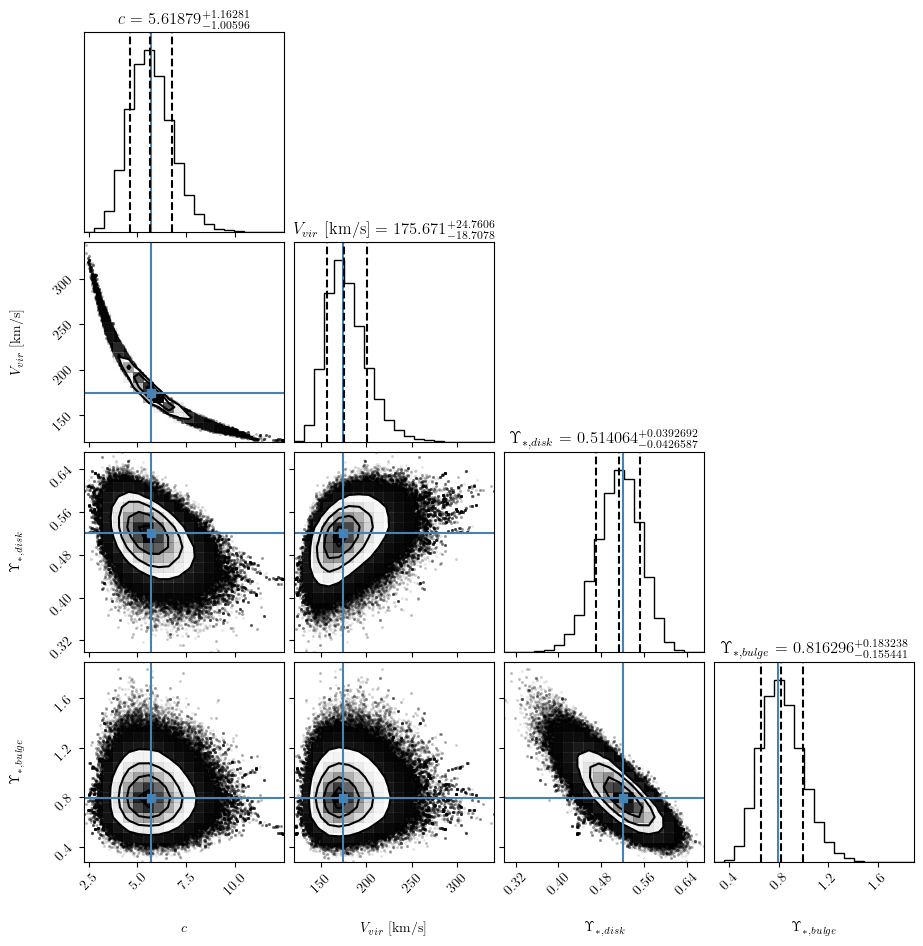

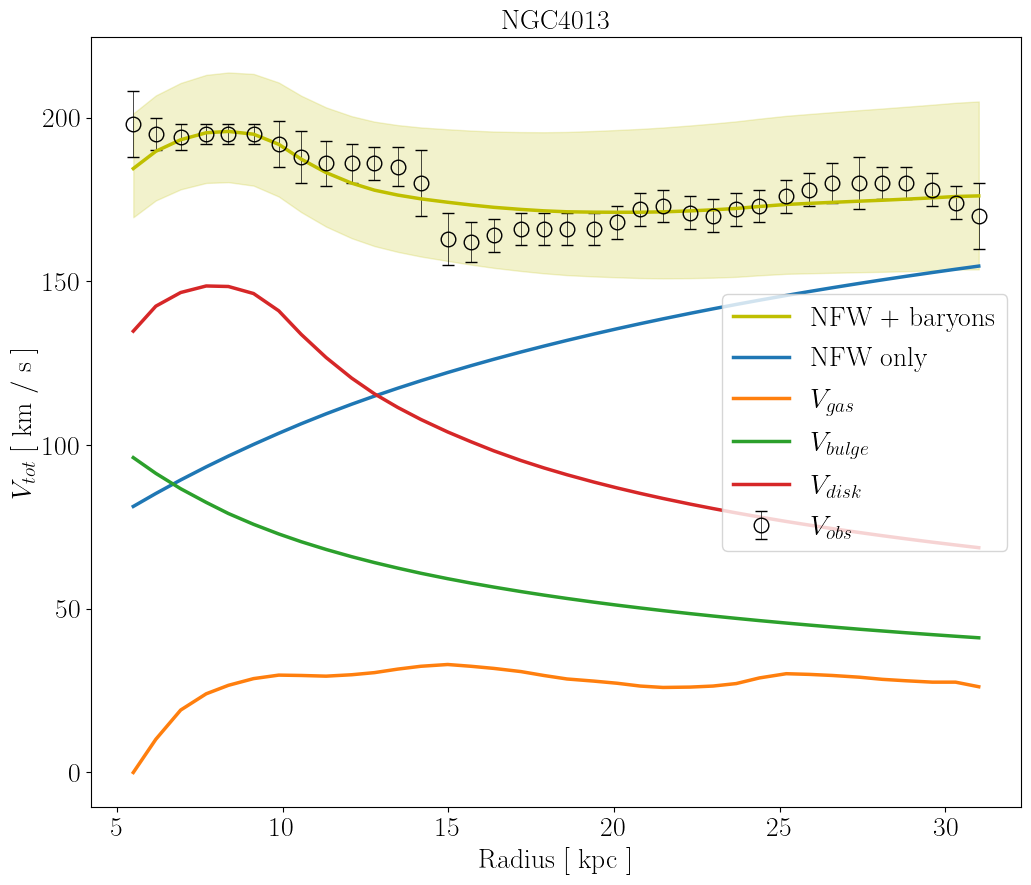

In [6]:
MCMC("NGC4013", vmodel, lprior, np.array([20, 100, 1, 1]))